# Clustering

In this notebook we will:

1. Create a synthetic dataset by:
    * selecting a few random centroids
    * create n random datapoints around each centroid
2. Plot the clusters created as from this synthetic data
3. Apply k-means to see if the algorithm can correctly find the clusters!
4. Play with hyperparameters to see how it works for yourself

## Setup & Imports

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['figure.figsize'] = [10, 5]

# Model
### K-MEANS
Let's generate some clusters to show how K-Means reproduces them.

In [2]:
from sklearn.cluster import KMeans

In [3]:
# Key hyperparameters
true_k = 7          # desired number of clusters
colors = 'bgrykcm'  # colors for each cluster (b is blue, g is grey and so on)
dim_features = 2    # dimensionality of feature space
num_points = 40     # points per cluster

In [4]:
[f"{i}={c}" for i, c in enumerate(colors)]

['0=b', '1=g', '2=r', '3=y', '4=k', '5=c', '6=m']

[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]]


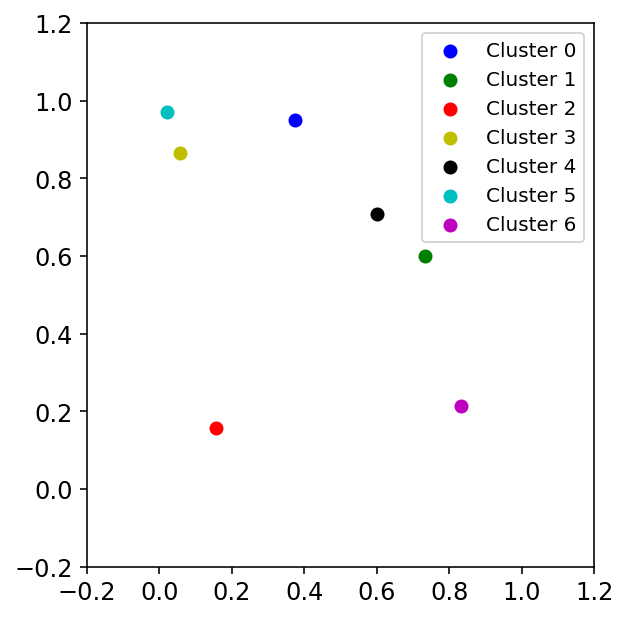

In [5]:
# Generating centroids randomly
true_centroids = np.random.rand(true_k, dim_features)
print(true_centroids)

if dim_features >= 2:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for i in range(true_k):
        plt.scatter(true_centroids[i, 0], true_centroids[i, 1], color=colors[i])
    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.2, 1.2)
    plt.legend([f"Cluster {i}" for i in range(len(colors))]);

Now that we have centroids let's generate synthetic datapoints around each center.
For this we will assume a multivariate normal distribution with a randomly generated covariance matrix.

In [6]:
# Key hyperparameters
sigma_xx = 0.01    # variance scale - how far can each new point be from the mean
sigma_xy = 0.01    # covariance scale - how far much correlation can x and y have (zero is none)
all_clusters = []  # store the points around each center, as a list of arrays (one array per cluster)

# Full list of data points
X = true_centroids
X.shape

(7, 2)

In [7]:
# Loop through the centroids
for centroid in true_centroids:
    random_data = np.array([[sigma_xx * np.random.rand(), sigma_xy * (2 * np.random.rand() - 1)],
                            [sigma_xy * (2 * np.random.rand() - 1), sigma_xx * np.random.rand()]])
    X_cluster = np.random.multivariate_normal(centroid, random_data, num_points)
    
    all_clusters.append(X_cluster)
    X = np.append(X, X_cluster, axis=0)

np.random.shuffle(X) # shuffle the array
X.shape

/Users/mattmacdonald/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


(287, 2)

Now let's plot the cluster data to visualize.

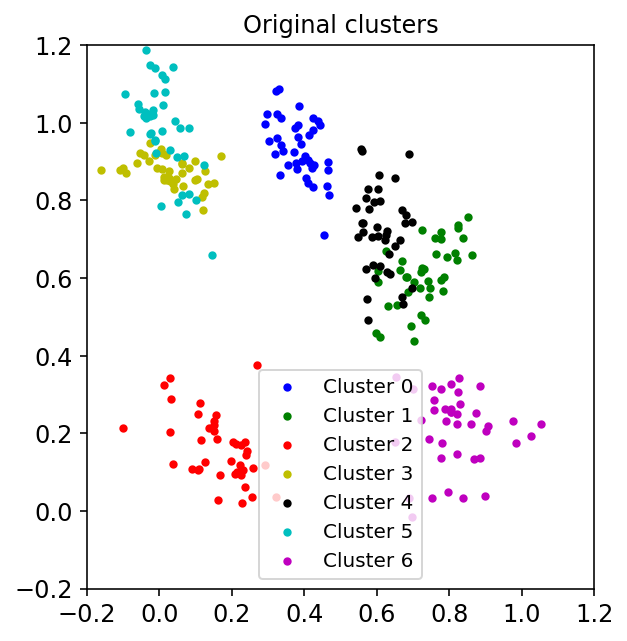

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for k in range(true_k):
    X_cluster = all_clusters[k]
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=colors[k], s=10)
plt.title("Original clusters")
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.legend([f"Cluster {i}" for i in range(len(colors))]);

Computing cluster labels is easy with sklearn.

In [9]:
kmeans = KMeans(n_clusters=true_k, random_state=0)
kmeans.fit(X)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [10]:
kmeans.cluster_centers_

array([[ 0.0715637 ,  0.84659956],
       [ 0.71281121,  0.59820253],
       [ 0.81795238,  0.20939709],
       [ 0.16375286,  0.16181093],
       [ 0.61086482,  0.74447641],
       [-0.0222704 ,  0.99272359],
       [ 0.39188393,  0.93903515]])

In [11]:
true_centroids

array([[0.37454012, 0.95071431],
       [0.73199394, 0.59865848],
       [0.15601864, 0.15599452],
       [0.05808361, 0.86617615],
       [0.60111501, 0.70807258],
       [0.02058449, 0.96990985],
       [0.83244264, 0.21233911]])

Let's visualize the learned clusters vs the true clusters.

Note that the colors do not match because the labels chosen by the clustering algorithm do not need to match the ones we started with.

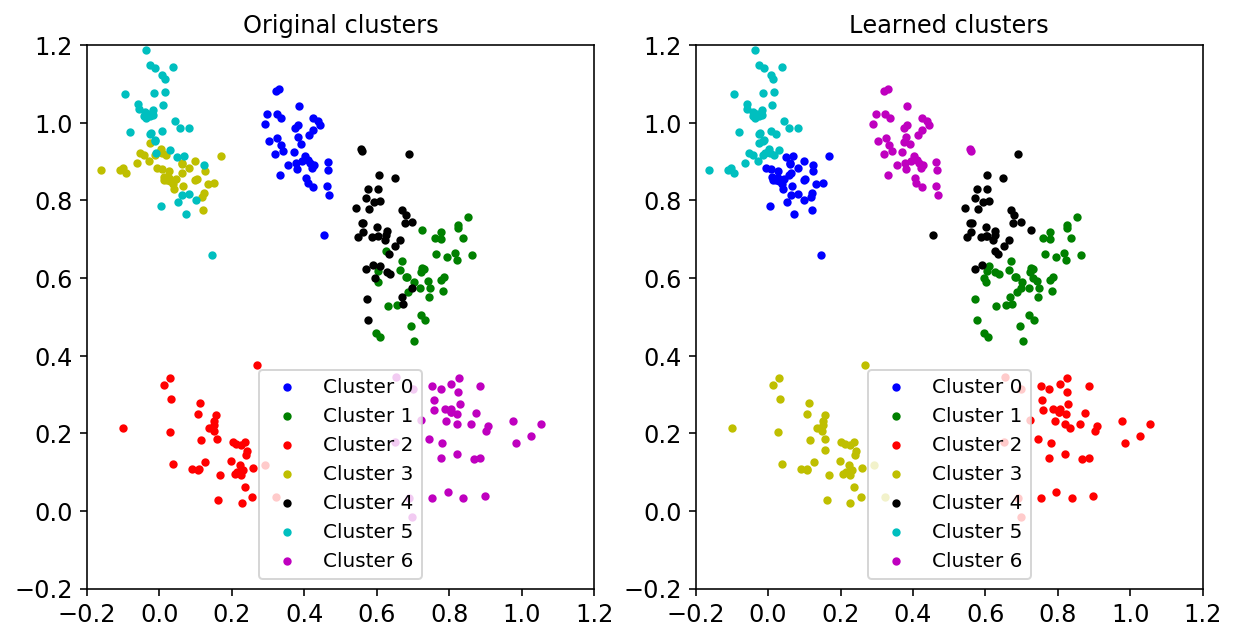

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
for k in range(true_k):
    X_cluster = all_clusters[k]
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=colors[k], s=10)
plt.title("Original clusters")
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.legend([f"Cluster {i}" for i in range(len(colors))])
    
plt.subplot(1, 2, 2)
for k in range(true_k):
    X_cluster = X[kmeans.labels_ == k]
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=colors[k], s=10)
plt.title("Learned clusters")
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.legend([f"Cluster {i}" for i in range(len(colors))]);

# Tune
Measure the performance of the clustering.

A function that measures the _cost_ of a specific clustering is called _inertia_

Inertia is computed as the sum of the square distances between each point and the center of the cluster to which the point is assigned. Inertia is one of the attributes of the learned model.
A complementary measure of performance is to look at what below is called inertia2, which is the sum of the squares distances between each point and the 2nd closest cluster.

A quality clustering solution should have small inertia, and large inertia2: that means:

    1. points are close to the center of their assigned cluster
    2. points are far from the center of other clusters (as represented by the second closest cluster)

In [13]:
def get_inertia(X, kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for i in range(X.shape[0]):
        inertia = inertia + np.linalg.norm(X[i] - kmeans.cluster_centers_[kmeans.labels_[i]])**2
    return inertia

In [14]:
kmeans.inertia_

2.9668155282720114

In [15]:
get_inertia(X, kmeans)

2.9668155282720132

In [16]:
def get_inertia2(X, kmeans):
    ''' This function is analogous to get_inertia, but with respect to the 2nd closest center, rather than closest one'''
    closest_index = 1
    if len(kmeans.cluster_centers_) == 1:
        closest_index = 0  # in case only one cluster is found
    
    inertia2 = 0
    for i in range(X.shape[0]):
        dist_to_center = sorted([np.linalg.norm(X[i] - center)**2 
                                 for center in kmeans.cluster_centers_])[closest_index]
        inertia2 = inertia2 + dist_to_center
    return inertia2

In [17]:
get_inertia2(X, kmeans)

32.40166131326723

In addition to _inertia_ we compute the ratio between _interia_ and _inertia2_. 

In [18]:
get_inertia(X, kmeans) / get_inertia2(X, kmeans)

0.09156368556501196

Another performance measure is called _silhouette_, which we want to maximize instead:

The silhouette $s(x)$ for a point $x$ is defined as:

$$ s(x) = \frac{b(x)-a(x)}{\max\{a(x),b(x)\}} $$

where 

- $a(x)$ is the average distance between $x$ and the points in the cluster $x$ belongs to (_cohesion_)

- $b(x)$ is the smallest average distance between $x$ and the points the clusters $x$ does not belong to (_seperation_)

$s(x)$ is a quantity in $[-1,1]$. The silhouette score is the average silhouette score among all the points: $\frac{1}{|X|} \sum_x s(x)$

In [19]:
from sklearn.metrics import silhouette_score

In [20]:
silhouette_score(X, kmeans.labels_)

0.514295200812474

Let's use the scores to find the best k value for a range of k hyperparameters.

In [21]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []

max_k = 15
for k in np.arange(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)  
    inertias_1.append(kmeans.inertia_)
    inertias_2.append(get_inertia2(X, kmeans))
    print(f"[k {k: >2}]",
          f"interia: {inertias_1[-1]: >6.2f},",
          f"inertia2: {inertias_2[-1]: >6.2f},",
          f"ratio: {inertias_1[-1] / inertias_2[-1]:.2f}")

    if k > 1:
        silhouette_avgs.append(silhouette_score(X, kmeans.labels_))

[k  1] interia:  58.94, inertia2:  58.94, ratio: 1.00
[k  2] interia:  27.28, inertia2: 156.31, ratio: 0.17
[k  3] interia:  14.10, inertia2: 127.49, ratio: 0.11
[k  4] interia:   7.69, inertia2:  90.01, ratio: 0.09
[k  5] interia:   4.20, inertia2:  54.50, ratio: 0.08
[k  6] interia:   3.58, inertia2:  42.95, ratio: 0.08
[k  7] interia:   2.97, inertia2:  32.40, ratio: 0.09
[k  8] interia:   2.69, inertia2:  18.41, ratio: 0.15
[k  9] interia:   2.36, inertia2:  16.75, ratio: 0.14
[k 10] interia:   2.10, inertia2:  11.56, ratio: 0.18
[k 11] interia:   1.88, inertia2:  10.32, ratio: 0.18
[k 12] interia:   1.71, inertia2:  10.09, ratio: 0.17
[k 13] interia:   1.62, inertia2:   9.29, ratio: 0.17
[k 14] interia:   1.50, inertia2:   6.97, ratio: 0.21
[k 15] interia:   1.36, inertia2:   6.49, ratio: 0.21


In [22]:
k = 2
for avg in silhouette_avgs:
    print(f"[k {k: >2}] silhouette: {avg:.2f}")
    k += 1

[k  2] silhouette: 0.50
[k  3] silhouette: 0.59
[k  4] silhouette: 0.61
[k  5] silhouette: 0.62
[k  6] silhouette: 0.57
[k  7] silhouette: 0.51
[k  8] silhouette: 0.47
[k  9] silhouette: 0.47
[k 10] silhouette: 0.44
[k 11] silhouette: 0.43
[k 12] silhouette: 0.44
[k 13] silhouette: 0.43
[k 14] silhouette: 0.39
[k 15] silhouette: 0.39


Let's see what that looks like plotted.

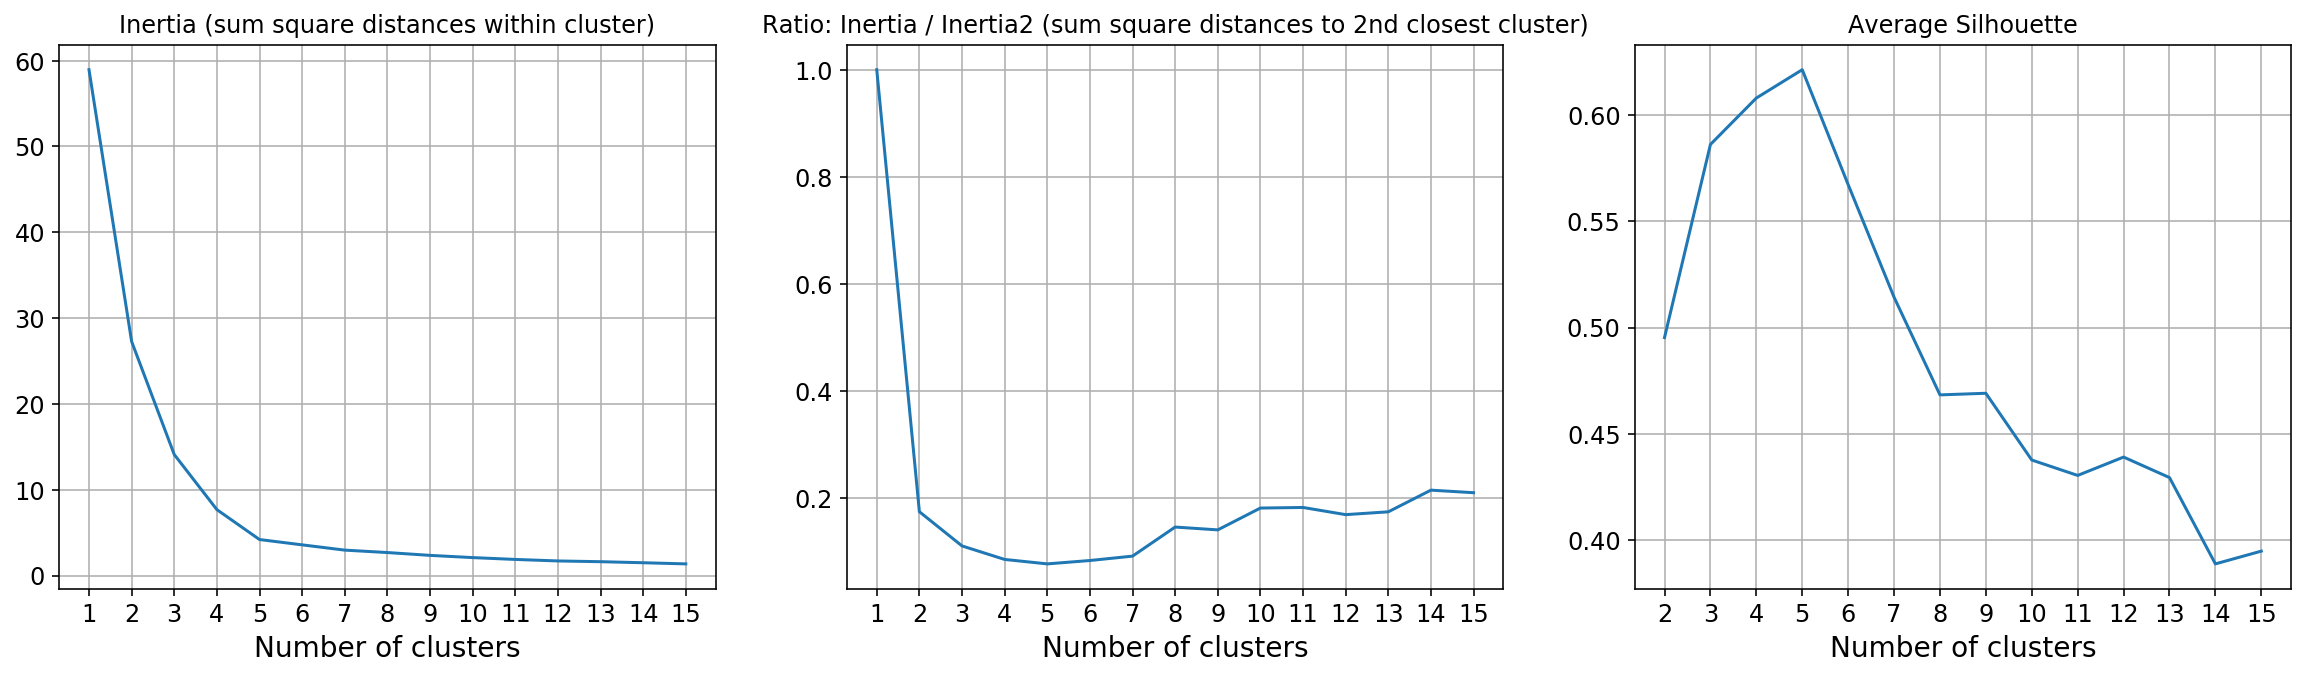

In [23]:
plt.figure(figsize=(20, 5))

k_range = np.arange(1, max_k + 1)

plt.subplot(1,3,1)
plt.title("Inertia (sum square distances within cluster)")
plt.plot(k_range, inertias_1)
plt.xticks(k_range)
plt.xlabel('Number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia / Inertia2 (sum square distances to 2nd closest cluster)")
plt.plot(k_range, np.array(inertias_1) / np.array(inertias_2))
plt.xticks(k_range)
plt.xlabel('Number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(k_range[1:], silhouette_avgs)
plt.xticks(k_range[1:])
plt.xlabel('Number of clusters')
plt.grid()

Analyze the plots to determine the optimal value of $k$

In this case the data was created to have $k$ clusters, but in practice this is of course unknown, and one of the user's tasks is to determine the appropriate value of $k$.

In the first case (looking at inertias) what we are looking for is an "elbow" in the graph. Notice that we do not choose the value of $k$ with the smallest value since the inertia keeps decreasing as $k$ increases. This will always be the case.

When looking at the ratio between inertia_1 and inertia_2, one looks for a minimum value.

The silhouette gives higher values for best clusterings, so what we look for is a maximum value.

With real data (non-synthetic) it is trickier to find the best value of $k$ since it is often not obvious as it is in the example above. Often there are a few options that seem reasonable and there may be significant overlap between groups. Having these 3 differents approaches to determine a convenient value of $k$ should help in narrowing down this hyperparameter.

# Model Using Real Data
### K-MEANS
The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper _The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis_.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed an early classifer model distinguish the species from each other.

In [24]:
from sklearn.datasets import load_iris
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [25]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [26]:
X.shape

(150, 4)

In [27]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Text(0, 0.5, 'Petal width')

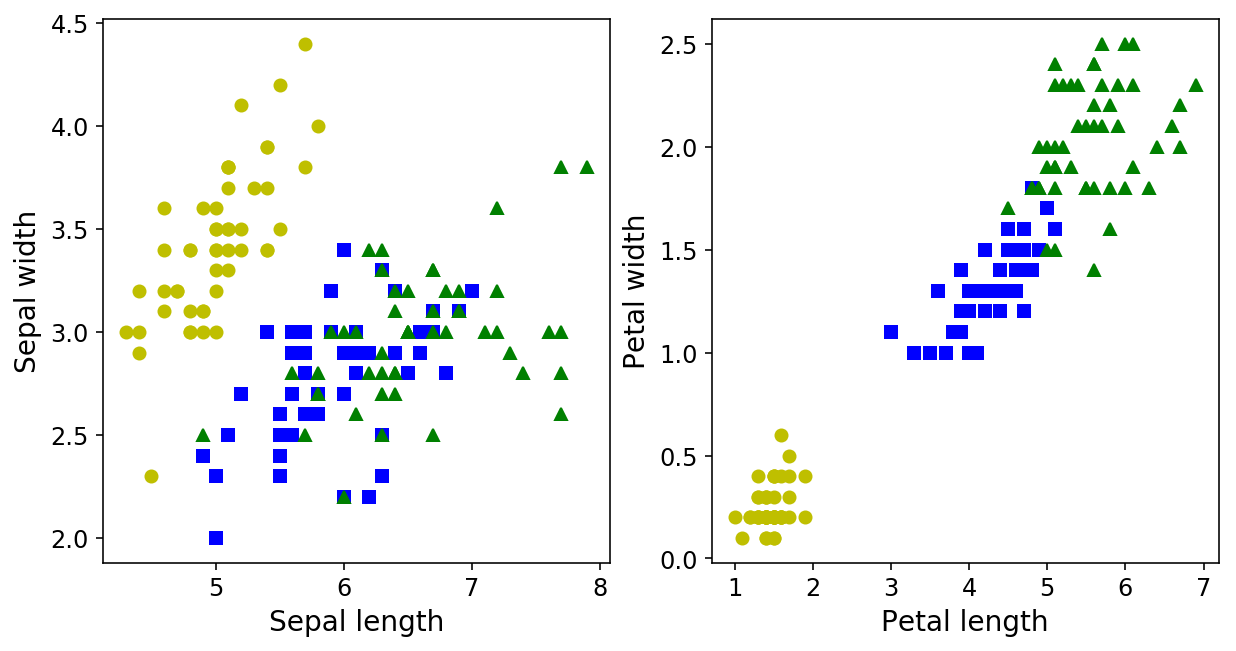

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.xlabel("Sepal length", fontsize=14)
plt.ylabel("Sepal width", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)

In [29]:
# YOUR CODE HERE

# Other Models

### Gaussian Mixture Models
Another powerful clustering algorithm is gaussian mixture models. They fit a set of multi-dimensional normal probability distributions to the data to form the clusters. This gives a similar grouping to K-Means but with the added benefit of providing probabilities of points belonging to clusters for outlier detection.

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
gaussian = GaussianMixture(n_components=3, random_state=42)
y_pred = gaussian.fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

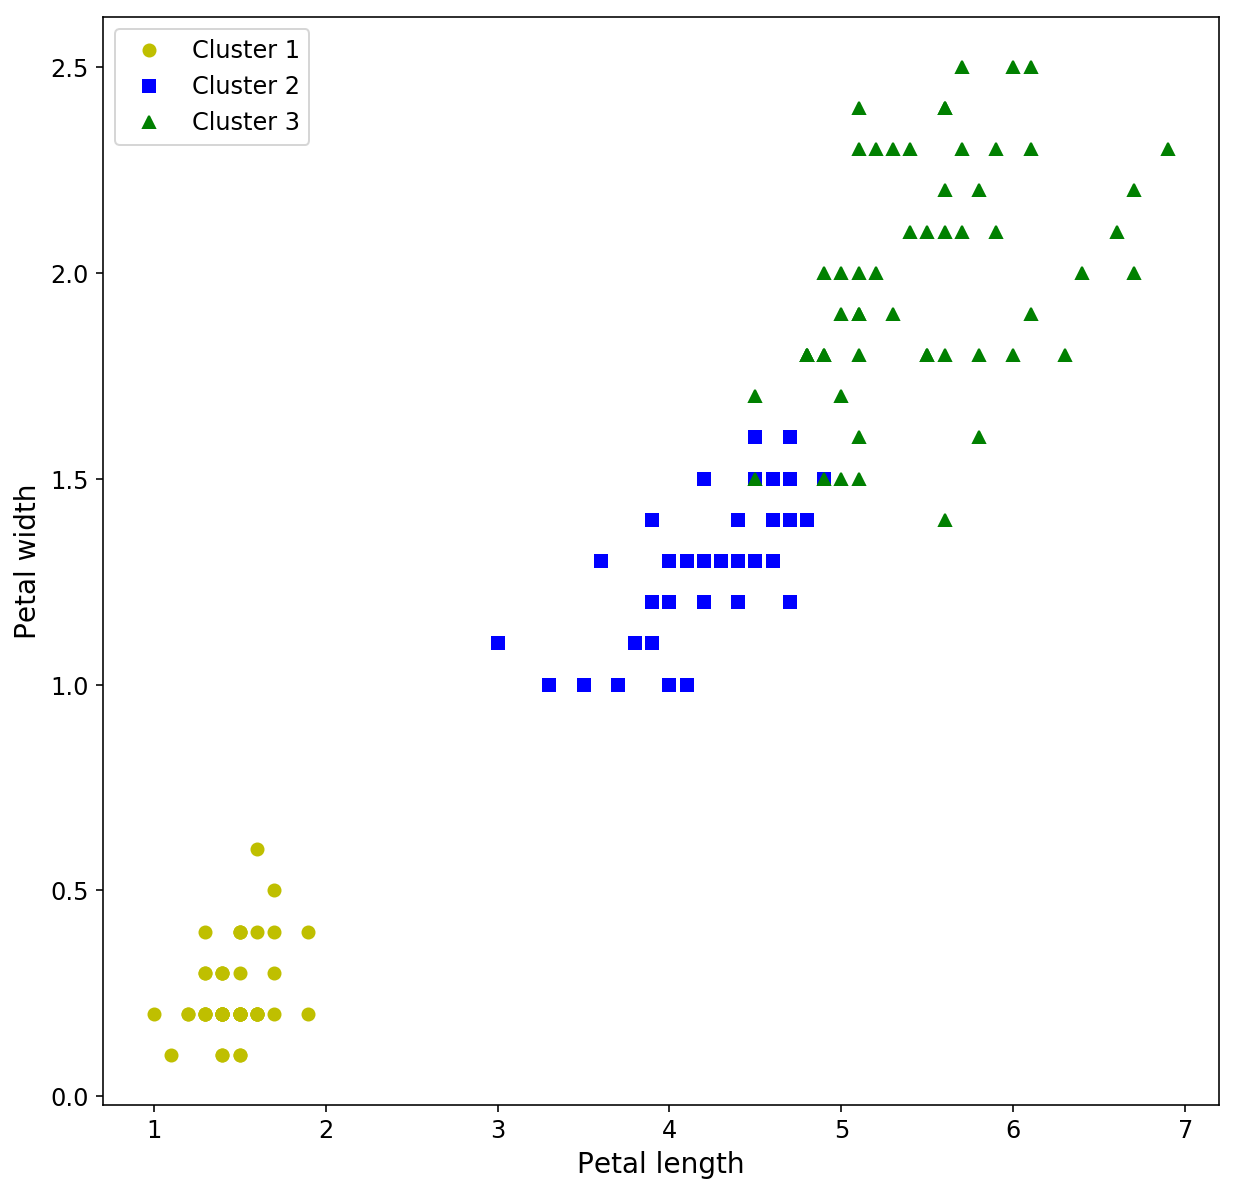

In [32]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12);

In [33]:
# Probabilities of membership in each cluster
gaussian.predict_proba(X)[:5]

array([[6.06216336e-35, 1.00000000e+00, 1.01178227e-43],
       [2.47801094e-28, 1.00000000e+00, 9.23008233e-31],
       [4.01248422e-30, 1.00000000e+00, 1.02746863e-35],
       [2.59713998e-26, 1.00000000e+00, 1.59307037e-31],
       [2.54371410e-35, 1.00000000e+00, 3.78557282e-46]])

### DBSCAN
We will generate a new data set for this example by creating blobs.

In [34]:
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [35]:
n = 1000
noisy_circles = datasets.make_circles(n_samples=n, factor=.5, noise=.07)
noisy_moons = datasets.make_moons(n_samples=n, noise=.1)
blobs = datasets.make_blobs(n_samples=n, random_state=8)

In [36]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
clustering_names = ['KMeans', 'DBSCAN']

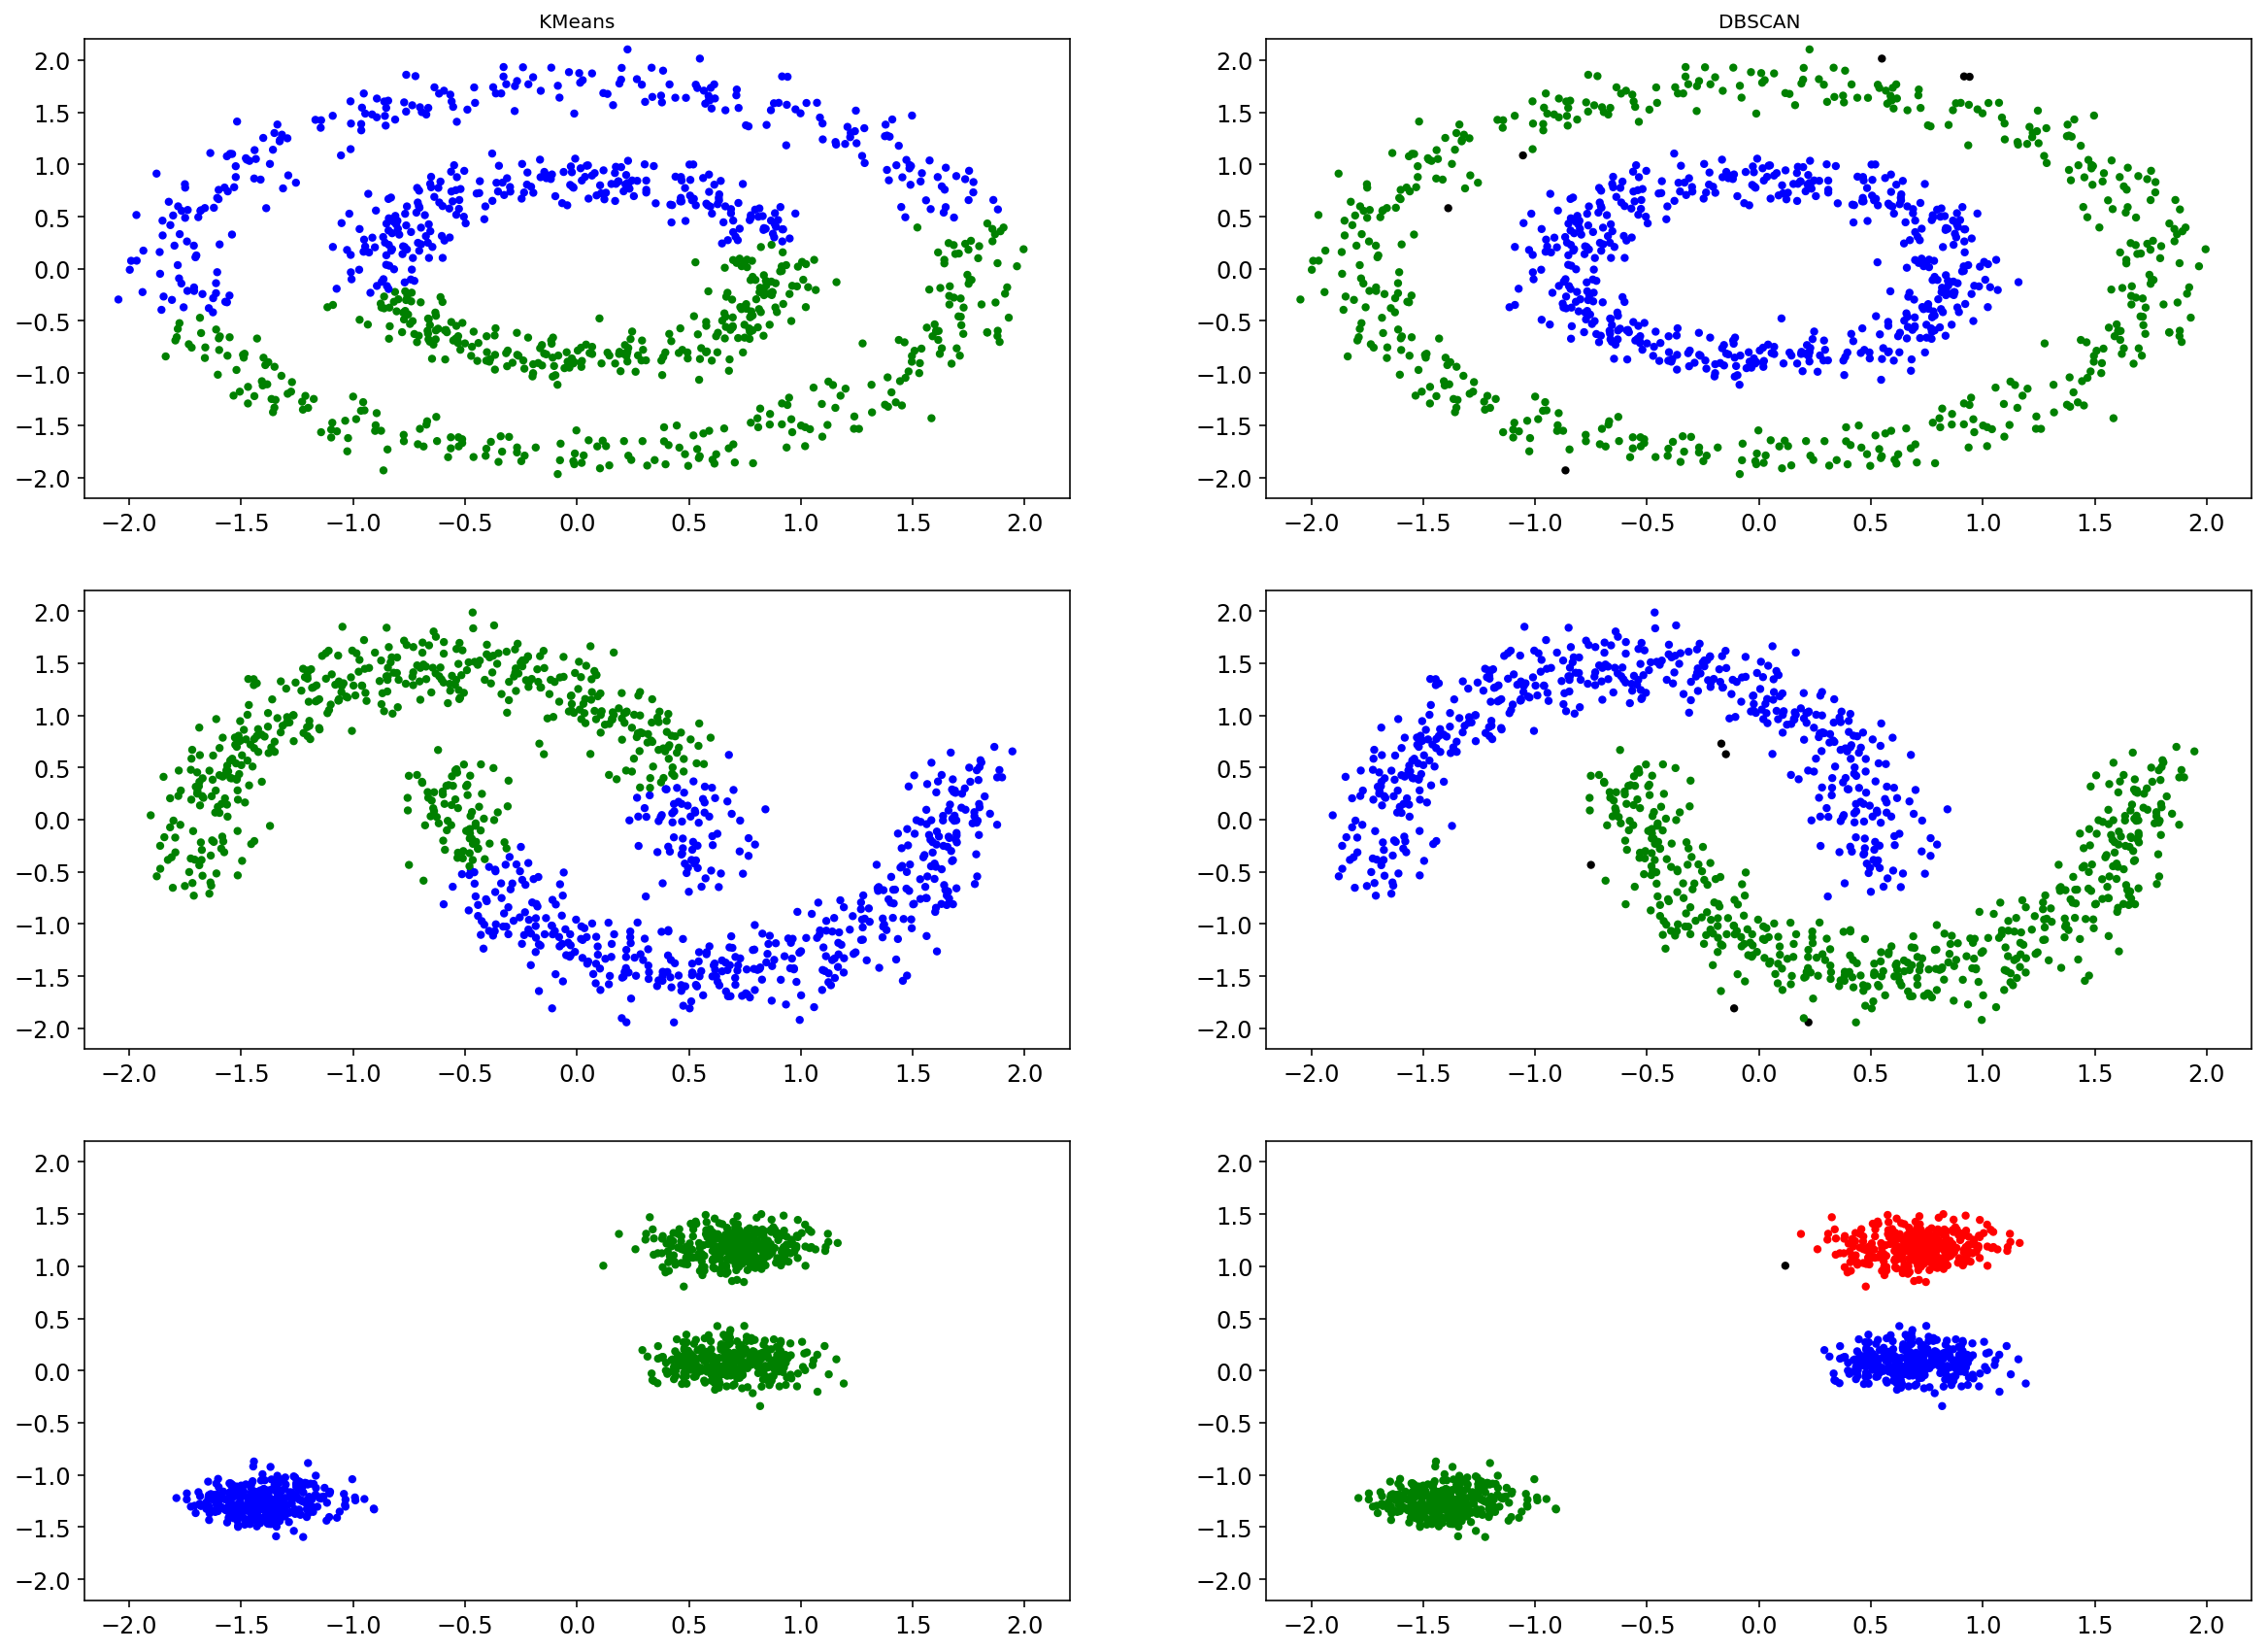

In [37]:
plt.figure(figsize=(20, 20))

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    # Standardize dataset
    X = StandardScaler().fit_transform(X)

    # Create clustering estimators
    kmeans = cluster.KMeans(n_clusters=2)
    dbscan = cluster.DBSCAN(eps=.2, min_samples=5)

    clustering_algorithms = [kmeans, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # Predict clusters
        algorithm.fit(X)
        y_pred = algorithm.labels_.astype(np.int)

        # Plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=10)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        plt.xlim(-2.2, 2.2)
        plt.ylim(-2.2, 2.2)
        plot_num += 1

Based on the first 2 (top) shapes, DBSCAN does a better job at identifying the true underlying patterns.

Regarding the 3rd shape, it is open to discussion whether 2 or 3 clusters is more appropriate.

Outliers are depicted as black on the right scatterplots (DBSCAN)

### Hierarchical Clustering

For $k$ between 10 and 2 we can observe how hierarchical clustering works for different _linkage_ methods.

The _linkage_ is the criteria by which it is determined if 2 clusters are joined:

- ward: the clusters joined are those that result in minimum variance

- average: the clusters joined are those with minimum average distance between every pair of points (one in each cluster)

- complete: the clusters joined minimize the maximum distance between a pair of points, one in each cluster

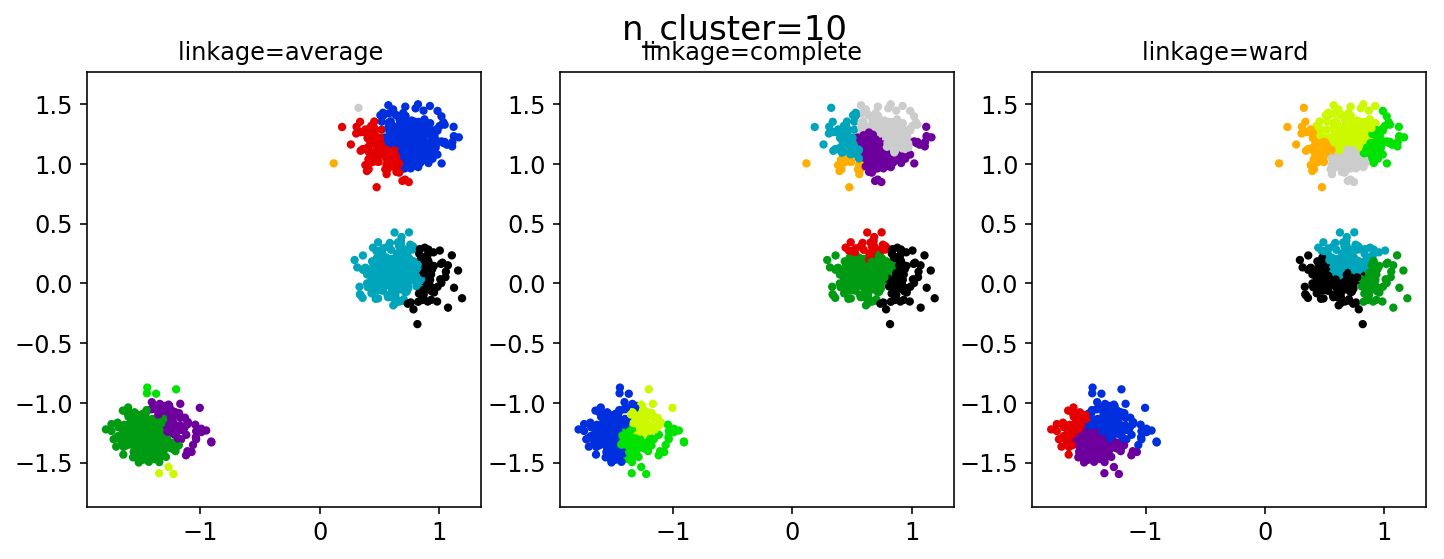

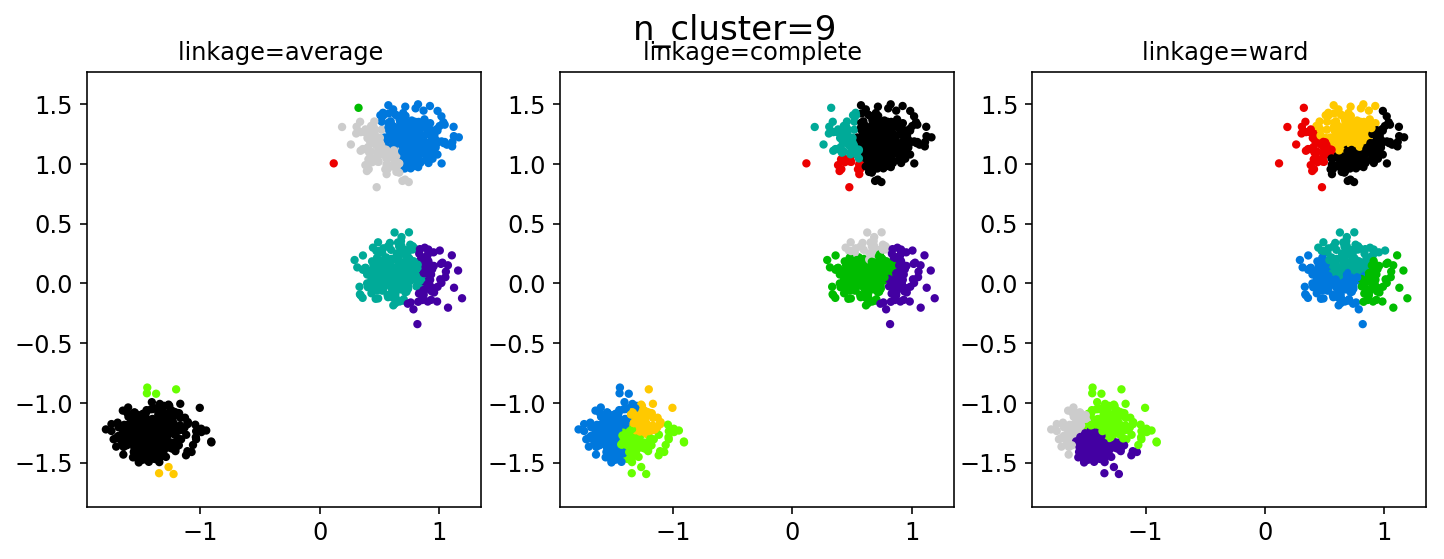

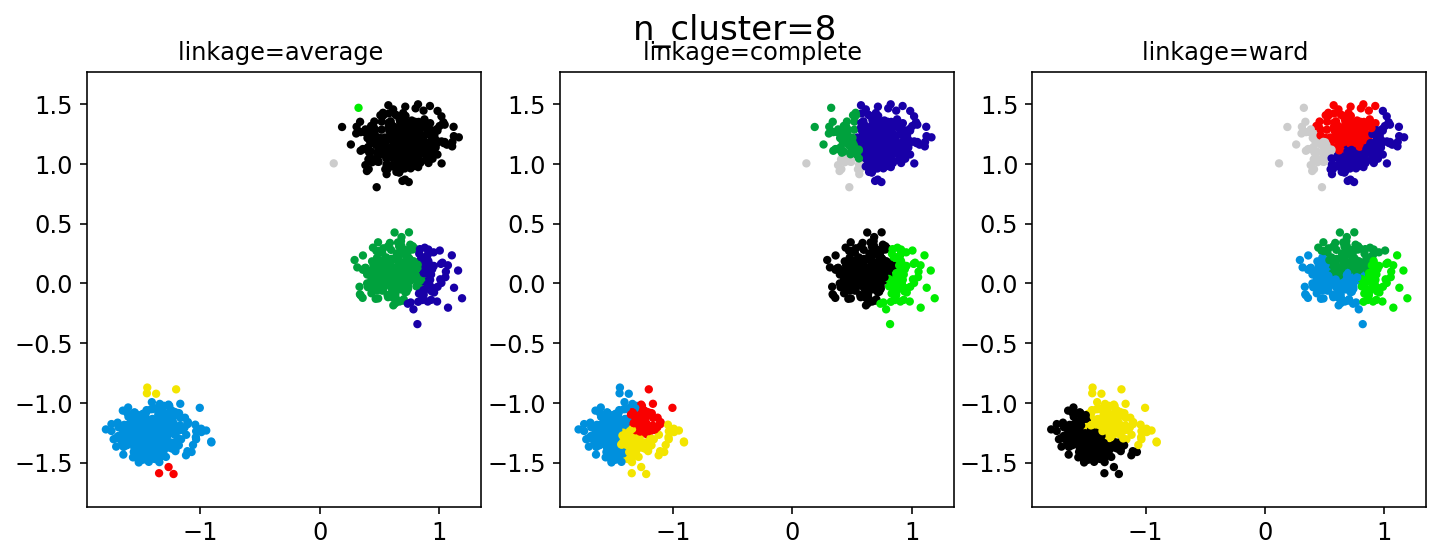

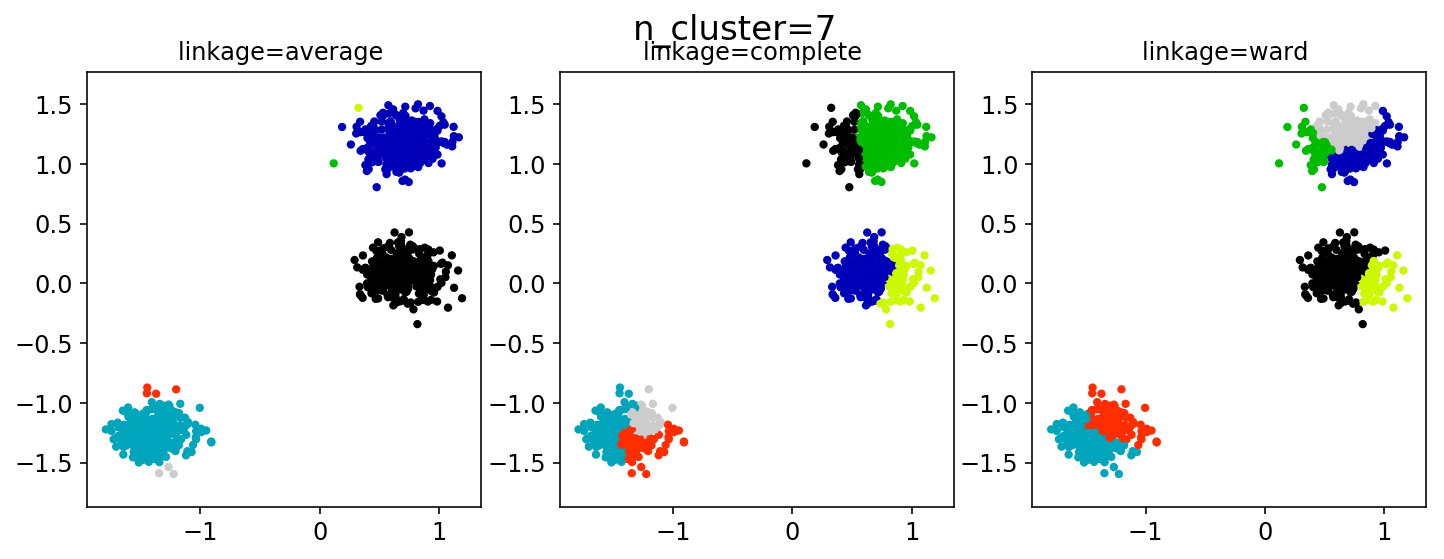

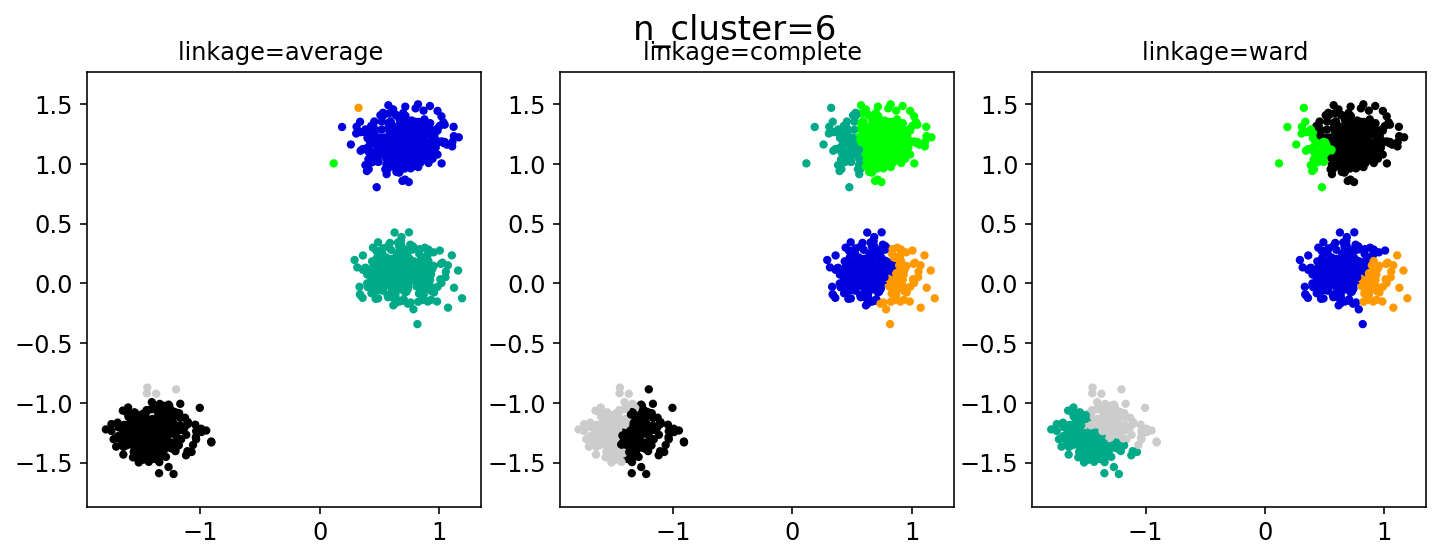

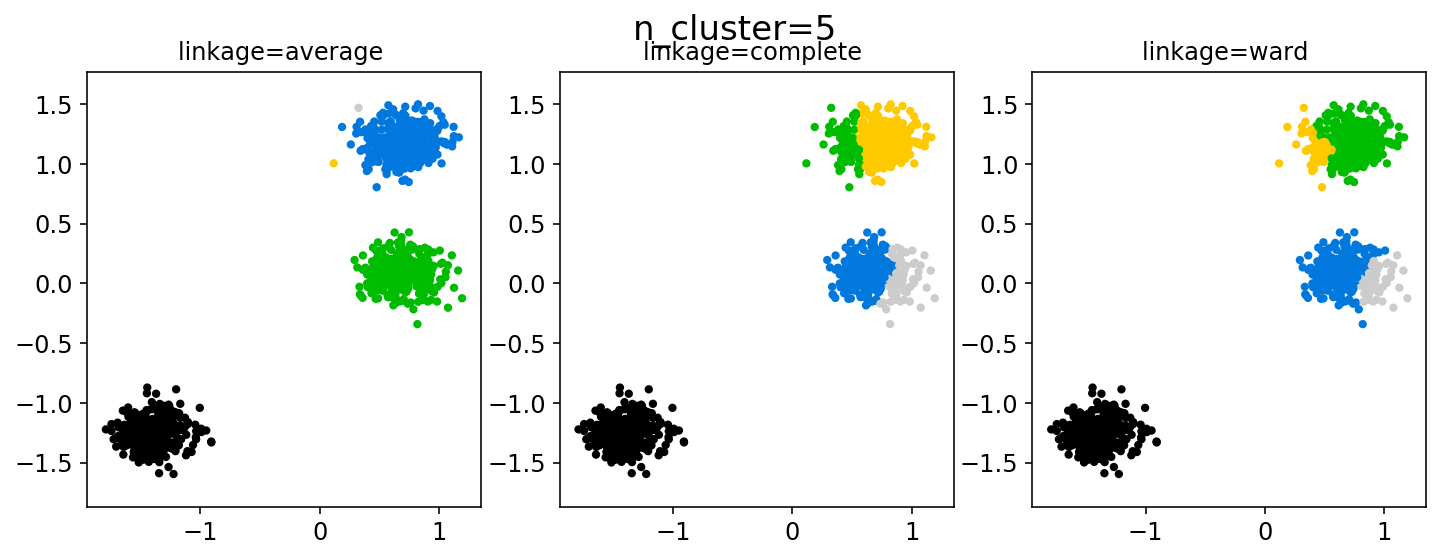

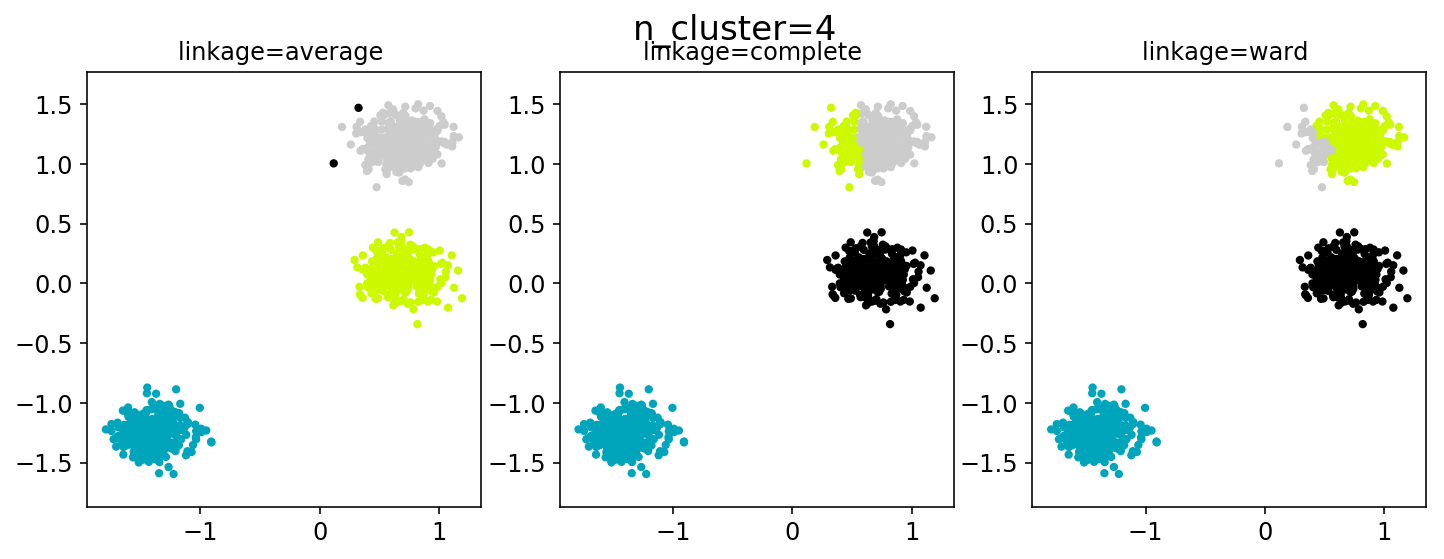

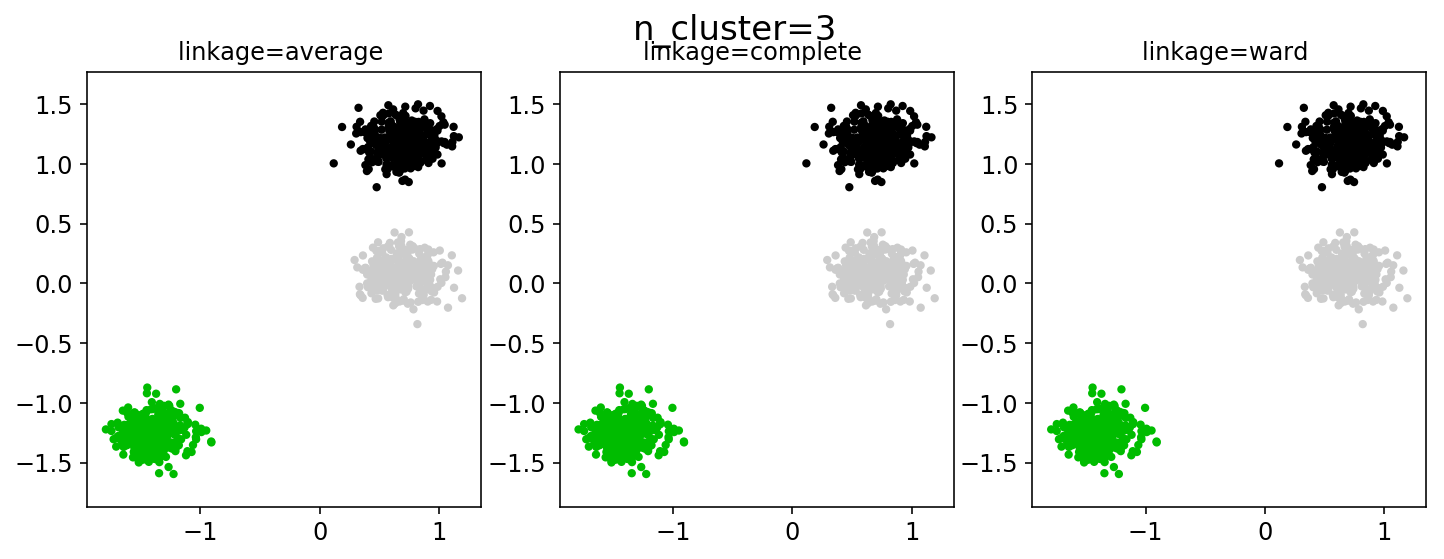

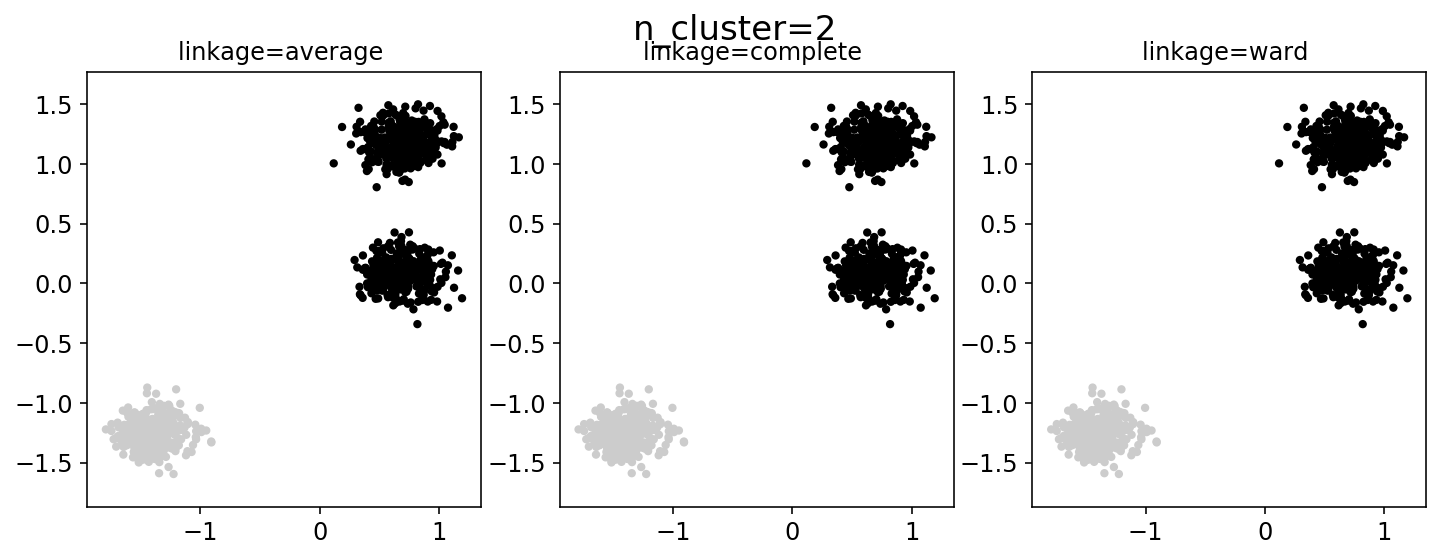

In [38]:
for k in reversed(np.arange(2,11)) :
    
    plt.figure(figsize=(12,4))
    for index, linkage in enumerate(('average', 'complete', 'ward')):
        
        plt.subplot(1, 3, index + 1)
        model = cluster.AgglomerativeClustering(linkage=linkage, n_clusters=k)
        model.fit(X)
        plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral, s=10)
        plt.title('linkage=%s ' % (linkage))
        plt.xlim(-0.2,1.2)
        plt.ylim(-0.2,1.2)
        plt.axis('equal')
        plt.suptitle('n_cluster=%i' % k, size=17);

Although the different linkage methods give different clusters (even for the same value of $k$), the clusterings are very similar for values around $k=5$ and less.

#### Dendrogram

The hierarchical clustering implementation in scipy provides a dendrogram to visualize the way clusters are joined.

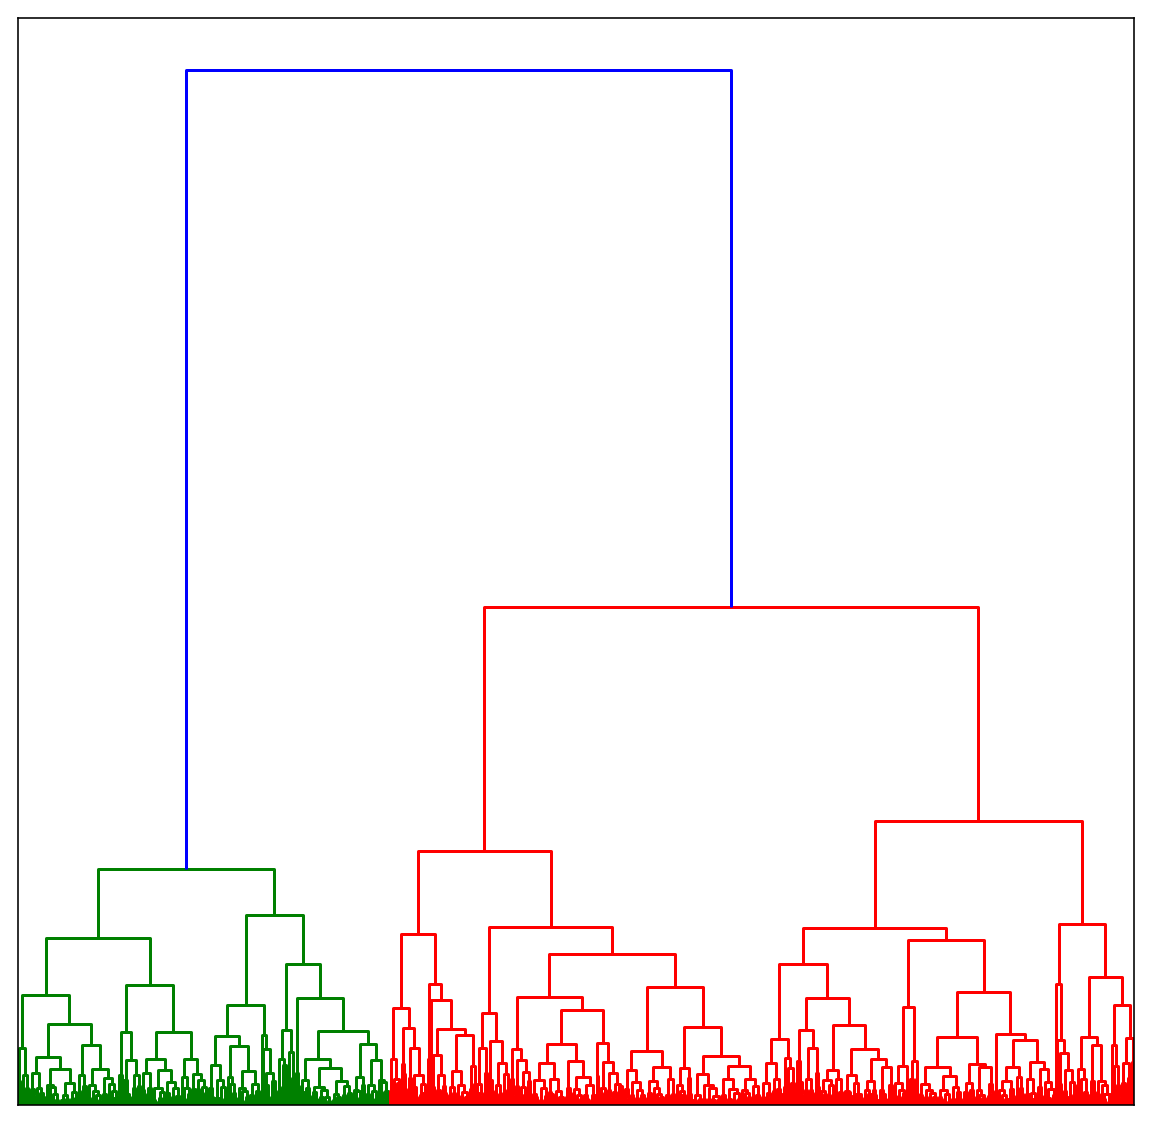

In [40]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z)
plt.xticks(())
plt.yticks(())
plt.show()